1. KURULUM

In [1]:
!pip -q install -U transformers datasets accelerate peft trl bitsandbytes huggingface_hub pyarrow pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 326.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 387.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 676.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 740.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 595.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 848.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.0 which is incompatibl

2. CONFIG + TOKEN + CSV YÜKLE + TEXT ÜRET

In [2]:
import os
from datasets import load_dataset
from huggingface_hub import login, hf_hub_download

# config
SMOKE_TEST = False  # True: hızlı test, False: gerçek run (2000/500)

DATASET_ID = "merve/tr-h4-norobots"
BASE_MODEL = "ytu-ce-cosmos/tr-Qwen2.5-0.5B-SFT-v1"

TRAIN_N = 200 if SMOKE_TEST else 2000
TEST_N  = 50  if SMOKE_TEST else 500
MAX_LEN = 256 if SMOKE_TEST else 512

OUT_DIR = "/content/outputs_sft_ensembles_smoke" if SMOKE_TEST else "/content/outputs_sft_ensembles"

# HF TOKEN (colab secret: kolektif_hg)
HF_TOKEN = ""
try:
    from google.colab import userdata
    HF_TOKEN = (userdata.get("kolektif_hg") or "").strip()
except Exception:
    HF_TOKEN = (os.getenv("HF_TOKEN") or "").strip()

print("HF token var mı? ->", bool(HF_TOKEN))
if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN
    login(token=HF_TOKEN)

# CSV dataset
train_csv = hf_hub_download(DATASET_ID, repo_type="dataset", filename="train_sft.csv", token=HF_TOKEN if HF_TOKEN else None)
test_csv  = hf_hub_download(DATASET_ID, repo_type="dataset", filename="test_sft.csv",  token=HF_TOKEN if HF_TOKEN else None)

ds = load_dataset("csv", data_files={"train": train_csv, "test": test_csv})
train_raw, test_raw = ds["train"], ds["test"]
print("Kolonlar:", train_raw.column_names)

def to_text(ex):
    p = "" if ex.get("prompt") is None else str(ex["prompt"]).strip()
    m = "" if ex.get("message") is None else str(ex["message"]).strip()
    cat = ex.get("category", "UNKNOWN")

    if p and m:
        text = f"### Prompt:\n{p}\n\n### Message:\n{m}"
    elif m:
        text = m
    else:
        text = p
    return {"text": text, "category": cat}

train_text = train_raw.map(to_text, remove_columns=train_raw.column_names)
test_text  = test_raw.map(to_text,  remove_columns=test_raw.column_names)

train_text = train_text.filter(lambda x: isinstance(x["text"], str) and len(x["text"].strip()) > 0)
test_text  = test_text.filter(lambda x: isinstance(x["text"], str) and len(x["text"].strip()) > 0)

print("train rows:", len(train_text), "test rows:", len(test_text))
print("\nÖrnek:\n", train_text[0]["text"][:250])
print("category:", train_text[0]["category"])

if len(train_text) < TRAIN_N:
    raise RuntimeError(f"Train {len(train_text)} satır. {TRAIN_N} için yetersiz.")
if len(test_text) < TEST_N:
    raise RuntimeError(f"Test {len(test_text)} satır. {TEST_N} için yetersiz.")


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


HF token var mı? -> True


train_sft.csv:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test_sft.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Kolonlar: ['idx', 'prompt', 'message', 'prompt_id', 'category']


Map:   0%|          | 0/9500 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/501 [00:00<?, ? examples/s]

train rows: 9500 test rows: 501

Örnek:
 ### Prompt:
Lütfen bu metindeki bilim adamlarının hedeflerini özetleyin: Üç gün içinde, iç içe geçmiş çimen yuvası tamamlandı ve onu gizlemek için sarkan otlardan oluşan bir gölgelik vardı. Ve onlarca yıl sonra, Kaliforniya Bilimler Akademisi'nde Rin
category: Summarize


3. SUBSETLER (R1/R2 RANDOM + T1/T2 TOPIC) + TEST SET

In [3]:
from collections import Counter

# test set (smoke: 50, full: 500) — shuffle ile sabitle
test_set = test_text.shuffle(seed=123).select(range(TEST_N))

# random subsetler
R1 = train_text.shuffle(seed=1).select(range(TRAIN_N))
R2 = train_text.shuffle(seed=2).select(range(TRAIN_N))

# topic (kategori) split - dengeli
cats = Counter(train_text["category"])
sorted_cats = [c for c,_ in cats.most_common()]

g1, g2 = set(), set()
s1 = s2 = 0
for c in sorted_cats:
    if s1 <= s2:
        g1.add(c); s1 += cats[c]
    else:
        g2.add(c); s2 += cats[c]

T1_pool = train_text.filter(lambda x: x["category"] in g1)
T2_pool = train_text.filter(lambda x: x["category"] in g2)

# random fallback (topic havuzu 2000/200’e yetmezse yine de proje aksın)
if len(T1_pool) < TRAIN_N or len(T2_pool) < TRAIN_N:
    print("Topic split yetmedi -> fallback random")
    T1 = train_text.shuffle(seed=3).select(range(TRAIN_N))
    T2 = train_text.shuffle(seed=4).select(range(TRAIN_N))
else:
    T1 = T1_pool.shuffle(seed=3).select(range(TRAIN_N))
    T2 = T2_pool.shuffle(seed=4).select(range(TRAIN_N))

# full: smokeda sadece TRAIN_N kadar seç
FULL = train_text.shuffle(seed=999).select(range(TRAIN_N)) if SMOKE_TEST else train_text

print("Subset sizes:", len(R1), len(R2), len(T1), len(T2), len(FULL), "Test:", len(test_set))
print("Top categories:", cats.most_common(10))


Filter:   0%|          | 0/9500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9500 [00:00<?, ? examples/s]

Subset sizes: 2000 2000 2000 2000 9500 Test: 500
Top categories: [('Generation', 4346), ('Open QA', 1182), ('Brainstorm', 1061), ('Chat', 795), ('Rewrite', 625), ('Summarize', 395), ('Coding', 334), ('Classify', 334), ('Closed QA', 245), ('Extract', 183)]


4. TOKENIZE (padding fix) + QLoRA LOADER + LoRA CONFIG (OTOMATİK target_modules)

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, default_data_collator
from peft import LoraConfig, prepare_model_for_kbit_training

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_batch(batch):
    out = tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length",
    )
    # labels: pad tokenları -100
    labels = []
    for ids, am in zip(out["input_ids"], out["attention_mask"]):
        labels.append([tok if mask == 1 else -100 for tok, mask in zip(ids, am)])
    out["labels"] = labels
    return out

def tok(ds_):
    t = ds_.map(tokenize_batch, batched=True, remove_columns=ds_.column_names)
    t.set_format(type="torch")
    return t

test_tok = tok(test_set)
R1_tok, R2_tok, T1_tok, T2_tok, FULL_tok = map(tok, [R1, R2, T1, T2, FULL])

collator = default_data_collator
print("Tokenized length:", len(R1_tok[0]["input_ids"]))

def load_qlora_base():
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16,
    )
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        quantization_config=bnb_cfg,
        device_map="auto",
        trust_remote_code=True
    )
    model.config.use_cache = False
    model.config.pad_token_id = tokenizer.pad_token_id
    model = prepare_model_for_kbit_training(model)
    return model

# LoRA target modül seçimi - farklı mimarilerde patlamasın diye otomatik
def pick_target_modules(model):
    leaf = set()
    for n, _ in model.named_modules():
        leaf.add(n.split(".")[-1])
    for cand in (["q_proj","k_proj","v_proj","o_proj"], ["c_attn","c_proj"]):
        ok = [c for c in cand if c in leaf]
        if ok:
            return ok
    return ["q_proj","v_proj"]

_tmp = load_qlora_base()
TARGET_MODULES = pick_target_modules(_tmp)
del _tmp
torch.cuda.empty_cache()

print("LoRA target_modules:", TARGET_MODULES)

LORA_CFG = LoraConfig(
    r=8 if SMOKE_TEST else 16,
    lora_alpha=16 if SMOKE_TEST else 32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9500 [00:00<?, ? examples/s]

Tokenized length: 512


model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

LoRA target_modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']


5. EĞİTİM (hızlı smoke: max_steps=30) + KAYDET + log CSV

In [5]:
import os, pandas as pd
from transformers import TrainingArguments, Trainer
from peft import get_peft_model

os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_EPOCHS = 1
TRAIN_BS = 2
GRAD_ACCUM = 4 if SMOKE_TEST else 8
LR = 2e-4
MAX_STEPS = 30 if SMOKE_TEST else -1  # fullde epoch bazlı

def train_lora(run_name, train_ds_tok):
    out_dir = f"{OUT_DIR}/{run_name}"
    os.makedirs(out_dir, exist_ok=True)

    model = load_qlora_base()
    model = get_peft_model(model, LORA_CFG)

    args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=TRAIN_EPOCHS,
        max_steps=MAX_STEPS,  # smoke: kısa, full: -1

        per_device_train_batch_size=TRAIN_BS,
        gradient_accumulation_steps=GRAD_ACCUM,
        learning_rate=LR,
        lr_scheduler_type="cosine",
        warmup_steps=10 if SMOKE_TEST else 50,

        logging_steps=5 if SMOKE_TEST else 25,
        report_to=[],  # boş - sürüm uyumu için

        save_strategy="no" if SMOKE_TEST else "steps",
        save_steps=200,
        save_total_limit=2,

        fp16=True,
        optim="paged_adamw_8bit",
        remove_unused_columns=False,
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds_tok,
        data_collator=collator,
    )
    trainer.train()

    # final adapter + tokenizer kaydet
    model.save_pretrained(out_dir)
    tokenizer.save_pretrained(out_dir)

    # log_history -> csv
    pd.DataFrame(trainer.state.log_history).to_csv(f"{out_dir}/train_log.csv", index=False)

    del model, trainer
    torch.cuda.empty_cache()
    return out_dir

runs = {}
for name, ds_tok_ in [("R1", R1_tok), ("R2", R2_tok), ("T1", T1_tok), ("T2", T2_tok), ("FULL", FULL_tok)]:
    runs[name] = train_lora(name, ds_tok_)

print("Eğitim bitti. Kayıt yeri:", OUT_DIR)
print(runs)


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,2.506693
50,2.235899
75,2.166422
100,2.123035
125,2.032582


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,2.535168
50,2.265592
75,2.137023
100,2.113156
125,2.099835


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,2.603217
50,2.336244
75,2.175596
100,2.128551
125,2.132606


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,2.475388
50,2.241181
75,2.089236
100,2.055314
125,2.005153


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,2.542292
50,2.265216
75,2.117828
100,2.141492
125,2.124859
150,2.077842
175,2.071029
200,2.020186
225,2.105317
250,2.064444


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Eğitim bitti. Kayıt yeri: /content/outputs_sft_ensembles
{'R1': '/content/outputs_sft_ensembles/R1', 'R2': '/content/outputs_sft_ensembles/R2', 'T1': '/content/outputs_sft_ensembles/T1', 'T2': '/content/outputs_sft_ensembles/T2', 'FULL': '/content/outputs_sft_ensembles/FULL'}


6. EVAL (loss/ppl) + MERGE (R1+R2, T1+T2) + SONUÇ TABLOSU

In [6]:
# PRECHECK

# 5 step
PRECHECK_STEPS = 5

# MAX_STEPS - geçici
_old_max_steps = MAX_STEPS
MAX_STEPS = PRECHECK_STEPS
print("Precheck: MAX_STEPS =", MAX_STEPS)

# sadece R1 ile deneme
_ = train_lora("R1_preflight", R1_tok)

# geri al
MAX_STEPS = _old_max_steps
print("Precheck bitti. Full run'a geçebilirsin.")


Precheck: MAX_STEPS = 5


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


✅ Precheck bitti. Full run'a geçebilirsin.


In [7]:
import math, pandas as pd
from peft import PeftModel
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM

def eval_adapter(adapter_dir):
    model = load_qlora_base()
    model = PeftModel.from_pretrained(model, adapter_dir)
    model.eval()

    args = TrainingArguments(
        output_dir=f"{OUT_DIR}/_tmp_eval",
        per_device_eval_batch_size=4,
        fp16=True,
        report_to=[],
        remove_unused_columns=False,
        dataloader_pin_memory=False,
    )
    trainer = Trainer(model=model, args=args, eval_dataset=test_tok, data_collator=collator)
    metrics = trainer.evaluate()
    loss = float(metrics["eval_loss"])
    ppl = math.exp(loss) if loss < 20 else float("inf")

    del model, trainer
    torch.cuda.empty_cache()
    return {"eval_loss": loss, "ppl": ppl}

# MERGE: LoRA ağırlıklarını ortalama
def _get_adapter_sd(peft_model):
    try:
        from peft.utils import get_peft_model_state_dict
        return get_peft_model_state_dict(peft_model)
    except Exception:
        sd = peft_model.state_dict()
        return {k:v for k,v in sd.items() if "lora_" in k}

def _set_adapter_sd(peft_model, sd):
    try:
        from peft.utils import set_peft_model_state_dict
        set_peft_model_state_dict(peft_model, sd)
    except Exception:
        peft_model.load_state_dict(sd, strict=False)

def merge_adapters_average(adapter_a, adapter_b, out_dir, w_a=0.5, w_b=0.5):
    os.makedirs(out_dir, exist_ok=True)

    baseA = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype=torch.float16, device_map="cpu", trust_remote_code=True)
    mA = PeftModel.from_pretrained(baseA, adapter_a, is_trainable=False)
    sdA = _get_adapter_sd(mA)

    baseB = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype=torch.float16, device_map="cpu", trust_remote_code=True)
    mB = PeftModel.from_pretrained(baseB, adapter_b, is_trainable=False)
    sdB = _get_adapter_sd(mB)

    keys = sorted(set(sdA.keys()) | set(sdB.keys()))
    merged = {}
    for k in keys:
        if k in sdA and k in sdB:
            merged[k] = (w_a * sdA[k].float() + w_b * sdB[k].float()).half()
        elif k in sdA:
            merged[k] = sdA[k]
        else:
            merged[k] = sdB[k]

    baseM = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype=torch.float16, device_map="cpu", trust_remote_code=True)
    mM = PeftModel.from_pretrained(baseM, adapter_a, is_trainable=False)
    _set_adapter_sd(mM, merged)

    mM.save_pretrained(out_dir)
    tokenizer.save_pretrained(out_dir)
    return out_dir

merged_R = merge_adapters_average(runs["R1"], runs["R2"], f"{OUT_DIR}/MERGE_R")
merged_T = merge_adapters_average(runs["T1"], runs["T2"], f"{OUT_DIR}/MERGE_T")

results = {k: eval_adapter(v) for k,v in runs.items()}
results["MERGE_R"] = eval_adapter(merged_R)
results["MERGE_T"] = eval_adapter(merged_T)

df = pd.DataFrame(results).T.sort_values("eval_loss")
print(df)
df.to_csv(f"{OUT_DIR}/results_summary.csv", index=True)

print("\nÖzet kaydedildi:", f"{OUT_DIR}/results_summary.csv")


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

         eval_loss       ppl
FULL      2.036168  7.661192
R2        2.099437  8.161578
R1        2.099956  8.165807
T2        2.101409  8.177688
MERGE_T   2.104800  8.205464
T1        2.121433  8.343085
MERGE_R   2.181071  8.855784

Özet kaydedildi: /content/outputs_sft_ensembles/results_summary.csv


7. ZIP İNDİR

In [8]:
import shutil, os
zip_path = shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)
print("ZIP:", zip_path)


ZIP: /content/outputs_sft_ensembles.zip


8. BEST ADAPTER YÜKLE -> HF

In [9]:
PUSH_TO_HF = False  # True - upload eder
HF_REPO = "iclallalala/sft-ensembles-best-adapter"

if PUSH_TO_HF:
    from huggingface_hub import create_repo, upload_folder
    if not HF_TOKEN:
        raise RuntimeError("HF_TOKEN yok.")
    create_repo(HF_REPO, private=True, exist_ok=True, token=HF_TOKEN)

    # en iyi model (results_summary.csv'den)
    import pandas as pd
    df = pd.read_csv(f"{OUT_DIR}/results_summary.csv")
    best_name = df.sort_values("eval_loss").iloc[0]["Unnamed: 0"]
    best_dir = f"{OUT_DIR}/{best_name}"
    print("Best:", best_name, best_dir)

    upload_folder(
        repo_id=HF_REPO,
        folder_path=best_dir,
        repo_type="model",
        token=HF_TOKEN
    )
    print("HF’ye yüklendi:", HF_REPO)


9. GÖRSELLER

In [30]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

# --- güvenlik kontrolü
assert "OUT_DIR" in globals(), "OUT_DIR tanımlı değil."
FIG_DIR = f"{OUT_DIR}/figures"
os.makedirs(FIG_DIR, exist_ok=True)

res_path = f"{OUT_DIR}/results_summary.csv"
assert os.path.exists(res_path), f"{res_path} yok. Önce eval sonuçlarını üret."

# --- results oku
df = pd.read_csv(res_path)
if "Unnamed: 0" in df.columns:
    df = df.rename(columns={"Unnamed: 0":"run"})
else:
    df = df.rename(columns={df.columns[0]:"run"})
df = df.sort_values("eval_loss", ascending=True)

print(df)

       run  eval_loss       ppl
0     FULL   2.036168  7.661192
1       R2   2.099437  8.161578
2       R1   2.099956  8.165807
3       T2   2.101409  8.177688
4  MERGE_T   2.104800  8.205464
5       T1   2.121433  8.343085
6  MERGE_R   2.181071  8.855784


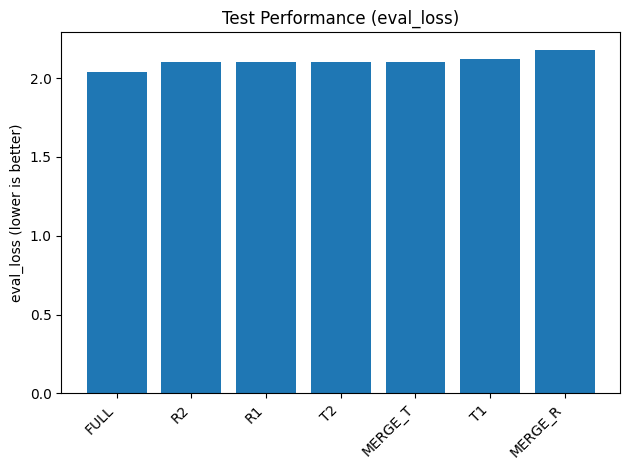

In [31]:
# 1) eval_loss bar
plt.figure()
plt.bar(df["run"], df["eval_loss"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("eval_loss (lower is better)")
plt.title("Test Performance (eval_loss)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eval_loss_bar.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()



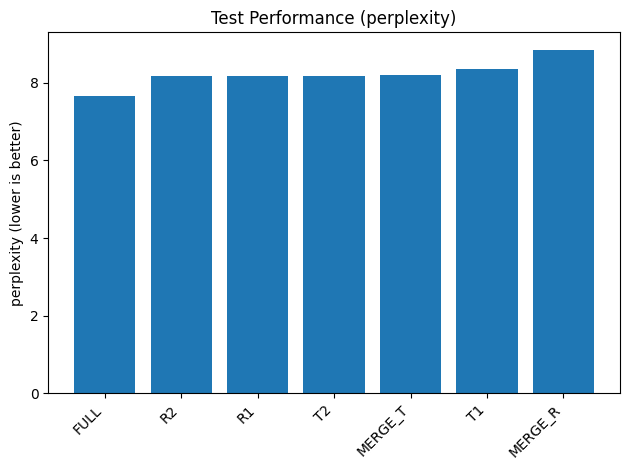

In [32]:
# 2) ppl bar
plt.figure()
plt.bar(df["run"], df["ppl"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("perplexity (lower is better)")
plt.title("Test Performance (perplexity)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/ppl_bar.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()

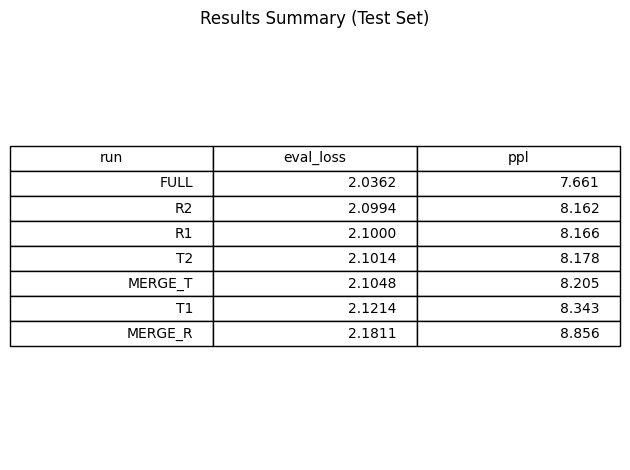

In [33]:
# 3) results table
plt.figure()
plt.axis("off")
table_df = df[["run","eval_loss","ppl"]].copy()
table_df["eval_loss"] = table_df["eval_loss"].map(lambda x: f"{x:.4f}")
table_df["ppl"] = table_df["ppl"].map(lambda x: f"{x:.3f}")
tbl = plt.table(cellText=table_df.values, colLabels=table_df.columns, loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)
plt.title("Results Summary (Test Set)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/results_table.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()

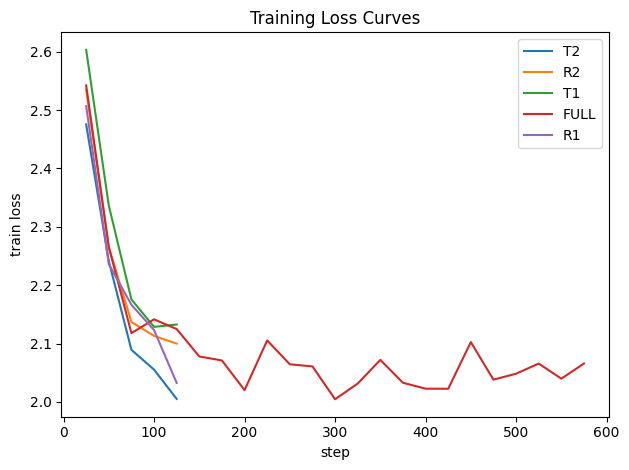

In [34]:
# 4) train loss curves
log_files = glob.glob(f"{OUT_DIR}/*/train_log.csv")
plt.figure()
any_plotted = False
xlabel = "step"
for lf in log_files:
    run = lf.split("/")[-2]
    d = pd.read_csv(lf)
    if "loss" not in d.columns:
        continue
    d2 = d.dropna(subset=["loss"])
    if d2.empty:
        continue

    if "step" in d2.columns and d2["step"].notna().any():
        x = d2["step"]; xlabel = "step"
    elif "epoch" in d2.columns and d2["epoch"].notna().any():
        x = d2["epoch"]; xlabel = "epoch"
    else:
        x = range(len(d2)); xlabel = "log_index"

    plt.plot(x, d2["loss"], label=run)
    any_plotted = True

if any_plotted:
    plt.xlabel(xlabel)
    plt.ylabel("train loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/train_loss_curves.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
    plt.show()
else:
    print("Loss için uygun log bulunamadı (train_log.csv kontrol et).")

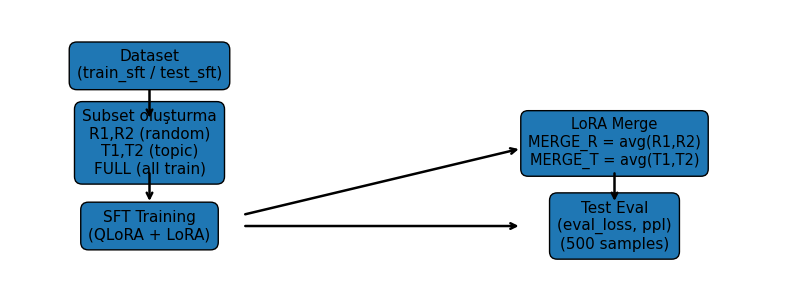

Saved: /content/outputs_sft_ensembles/figures/pipeline_diagram.png
Saved: /content/outputs_sft_ensembles/figures/pipeline_diagram.pdf


In [44]:
# 5) pipeline diagram
import os
import matplotlib.pyplot as plt

FIG_DIR = f"{OUT_DIR}/figures"
os.makedirs(FIG_DIR, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 3.6))
ax.axis("off")

def box(text, x, y, fs=11):
    ax.text(x, y, text, ha="center", va="center", fontsize=fs,
            bbox=dict(boxstyle="round,pad=0.5"))

def arrow(x1,y1,x2,y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                xycoords="axes fraction", textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1.8))

# kutular
box("Dataset\n(train_sft / test_sft)", 0.18, 0.80)
box("Subset oluşturma\nR1,R2 (random)\nT1,T2 (topic)\nFULL (all train)", 0.18, 0.52)
box("SFT Training\n(QLoRA + LoRA)", 0.18, 0.22)

box("LoRA Merge\nMERGE_R = avg(R1,R2)\nMERGE_T = avg(T1,T2)", 0.78, 0.52, fs=10.5)
box("Test Eval\n(eval_loss, ppl)\n(500 samples)", 0.78, 0.22)

# oklar (daha hizalı)
arrow(0.18, 0.72, 0.18, 0.60)   # Dataset -> Subset
arrow(0.18, 0.42, 0.18, 0.30)   # Subset -> Training

# Training kutusunun sağından çıkan iki ok
arrow(0.30, 0.22, 0.66, 0.22)   # Training -> Eval
arrow(0.30, 0.26, 0.66, 0.50)   # Training -> Merge (biraz yukarıdan)

arrow(0.78, 0.42, 0.78, 0.30)   # Merge -> Eval

ax.set_xlim(0,1)
ax.set_ylim(0,1)

png_path = f"{FIG_DIR}/pipeline_diagram.png"
pdf_path = f"{FIG_DIR}/pipeline_diagram.pdf"
plt.savefig(png_path, dpi=300, bbox_inches="tight", pad_inches=0.08)
plt.savefig(pdf_path, bbox_inches="tight", pad_inches=0.08)
plt.show()

print("Saved:", png_path)
print("Saved:", pdf_path)

In [36]:
import os, glob

print("OUT_DIR =", OUT_DIR)
print("Alt klasörler:", [p.split("/")[-1] for p in glob.glob(f"{OUT_DIR}/*") if os.path.isdir(p)])

# her run için temel dosyalar var mı?
for run in ["R1","R2","T1","T2","FULL","MERGE_R","MERGE_T"]:
    p = f"{OUT_DIR}/{run}"
    if os.path.isdir(p):
        print(run, "->", "OK",
              "| files:", [os.path.basename(x) for x in glob.glob(p+"/*")][:8])
    else:
        print(run, "-> YOK")


OUT_DIR = /content/outputs_sft_ensembles
Alt klasörler: ['T2', 'figures', 'R2', 'R1_preflight', 'MERGE_R', 'MERGE_T', '_tmp_eval_base', 'T1', 'FULL', 'R1', '_tmp_eval']
R1 -> OK | files: ['checkpoint-125', 'tokenizer_config.json', 'README.md', 'tokenizer.json', 'chat_template.jinja', 'train_log.csv', 'adapter_model.safetensors', 'adapter_config.json']
R2 -> OK | files: ['checkpoint-125', 'tokenizer_config.json', 'README.md', 'tokenizer.json', 'chat_template.jinja', 'train_log.csv', 'adapter_model.safetensors', 'adapter_config.json']
T1 -> OK | files: ['checkpoint-125', 'tokenizer_config.json', 'README.md', 'tokenizer.json', 'chat_template.jinja', 'train_log.csv', 'adapter_model.safetensors', 'adapter_config.json']
T2 -> OK | files: ['checkpoint-125', 'tokenizer_config.json', 'README.md', 'tokenizer.json', 'chat_template.jinja', 'train_log.csv', 'adapter_model.safetensors', 'adapter_config.json']
FULL -> OK | files: ['tokenizer_config.json', 'README.md', 'checkpoint-400', 'tokenizer.jso

In [37]:
import os, math, pandas as pd
from peft import PeftModel
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM

# eval
def eval_adapter(adapter_dir):
    model = load_qlora_base()
    model = PeftModel.from_pretrained(model, adapter_dir)
    model.eval()

    args = TrainingArguments(
        output_dir=f"{OUT_DIR}/_tmp_eval",
        per_device_eval_batch_size=4,
        fp16=True,
        report_to=[],
        remove_unused_columns=False,
        dataloader_pin_memory=False,
    )
    trainer = Trainer(model=model, args=args, eval_dataset=test_tok, data_collator=collator)
    metrics = trainer.evaluate()
    loss = float(metrics["eval_loss"])
    ppl = math.exp(loss) if loss < 20 else float("inf")
    del model, trainer
    import torch; torch.cuda.empty_cache()
    return {"eval_loss": loss, "ppl": ppl}

# merge (average LoRA)
def _get_adapter_sd(peft_model):
    try:
        from peft.utils import get_peft_model_state_dict
        return get_peft_model_state_dict(peft_model)
    except Exception:
        sd = peft_model.state_dict()
        return {k:v for k,v in sd.items() if "lora_" in k}

def _set_adapter_sd(peft_model, sd):
    try:
        from peft.utils import set_peft_model_state_dict
        set_peft_model_state_dict(peft_model, sd)
    except Exception:
        peft_model.load_state_dict(sd, strict=False)

def merge_adapters_average(adapter_a, adapter_b, out_dir, w_a=0.5, w_b=0.5):
    os.makedirs(out_dir, exist_ok=True)

    baseA = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype="auto", device_map="cpu", trust_remote_code=True)
    mA = PeftModel.from_pretrained(baseA, adapter_a, is_trainable=False)
    sdA = _get_adapter_sd(mA)

    baseB = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype="auto", device_map="cpu", trust_remote_code=True)
    mB = PeftModel.from_pretrained(baseB, adapter_b, is_trainable=False)
    sdB = _get_adapter_sd(mB)

    keys = sorted(set(sdA.keys()) | set(sdB.keys()))
    merged = {}
    for k in keys:
        if k in sdA and k in sdB:
            merged[k] = (w_a * sdA[k].float() + w_b * sdB[k].float()).half()
        elif k in sdA:
            merged[k] = sdA[k]
        else:
            merged[k] = sdB[k]

    baseM = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype="auto", device_map="cpu", trust_remote_code=True)
    mM = PeftModel.from_pretrained(baseM, adapter_a, is_trainable=False)
    _set_adapter_sd(mM, merged)

    mM.save_pretrained(out_dir)
    tokenizer.save_pretrained(out_dir)
    return out_dir

# merge klasörleri
merged_R = merge_adapters_average(f"{OUT_DIR}/R1", f"{OUT_DIR}/R2", f"{OUT_DIR}/MERGE_R")
merged_T = merge_adapters_average(f"{OUT_DIR}/T1", f"{OUT_DIR}/T2", f"{OUT_DIR}/MERGE_T")

# eval all
runs_dirs = {
  "R1": f"{OUT_DIR}/R1",
  "R2": f"{OUT_DIR}/R2",
  "T1": f"{OUT_DIR}/T1",
  "T2": f"{OUT_DIR}/T2",
  "FULL": f"{OUT_DIR}/FULL",
  "MERGE_R": merged_R,
  "MERGE_T": merged_T
}

results = {k: eval_adapter(v) for k,v in runs_dirs.items()}
df = pd.DataFrame(results).T.sort_values("eval_loss")
display(df)

df.to_csv(f"{OUT_DIR}/results_summary.csv", index=True)
print("Kaydedildi:", f"{OUT_DIR}/results_summary.csv")


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

,eval_loss,ppl
FULL,2.036168,7.661192
R2,2.099437,8.161578
R1,2.099956,8.165807
T2,2.101409,8.177688
MERGE_T,2.104800,8.205464
T1,2.121433,8.343085
MERGE_R,2.181071,8.855784


Kaydedildi: /content/outputs_sft_ensembles/results_summary.csv


In [39]:
import shutil
from google.colab import files

zip_path = shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)
print("ZIP:", zip_path)
files.download(zip_path)


ZIP: /content/outputs_sft_ensembles.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import shutil
from google.colab import files
fig_zip = shutil.make_archive(f"{OUT_DIR}/figures", 'zip', f"{OUT_DIR}/figures")
files.download(fig_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
import math, torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer

base_fp16 = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
base_fp16.config.use_cache = False
base_fp16.config.pad_token_id = tokenizer.pad_token_id
base_fp16.eval()

args = TrainingArguments(
    output_dir=f"{OUT_DIR}/_tmp_eval_base",
    per_device_eval_batch_size=4,
    fp16=True,
    report_to=[],
    remove_unused_columns=False,
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=base_fp16,
    args=args,
    eval_dataset=test_tok,
    data_collator=collator
)

m = trainer.evaluate()
base_loss = float(m["eval_loss"])
print("BASE eval_loss:", base_loss, "ppl:", math.exp(base_loss))

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

BASE eval_loss: 2.6213958263397217 ppl: 13.754909656950282


In [42]:
# overlap kontrol
print("T1 unique categories:", len(set(T1["category"])))
print("T2 unique categories:", len(set(T2["category"])))
print("Overlap categories:", len(set(T1["category"]) & set(T2["category"])))


T1 unique categories: 2
T2 unique categories: 8
Overlap categories: 0
